In [1]:
import torch
import higher
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
import scipy
import tqdm
import os
import copy
import argparse
import models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

## Start with a simple scenario where we train on fixed sources

In [2]:
n_samples = 50

Omega_b_arr = np.linspace(0.04, 0.06, n_samples)
Omega_c_arr = np.linspace(0.25, 0.35, n_samples)
h_arr = np.linspace(0.6, 0.8, n_samples)
sigma8_arr = np.linspace(0.7, 0.9, n_samples)
n_s_arr = np.linspace(0.9, 1.1, n_samples)

z= np.linspace(0., 3., 256)
z0 = 0.1
dndz = 1./(2.*z0) * (z / z0)**2 * np.exp(-z/z0)

l_arr = np.unique(np.geomspace(2, 60000, 30).astype(int))

if os.path.isfile('Cgg_data.npz'):
    data = np.load('Cgg_data.npz')
    Cgg_data = data['Cgg_data']
    l_arr = data['l_arr']
    Omega_b_arr = data['Omega_b_arr']
    Omega_c_arr = data['Omega_c_arr']
    h_arr = data['h_arr']
    sigma8_arr = data['sigma8_arr']
    n_s_arr = data['n_s_arr']
else:
    Cgg_data = np.zeros((n_samples, len(l_arr)))
    for i in tqdm.trange(n_samples):
        cosmo = ccl.Cosmology(Omega_c=Omega_c_arr[i], Omega_b=Omega_b_arr[i],
                            h=h_arr[i], sigma8=sigma8_arr[i], n_s=n_s_arr[i])
        lensTracer = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz))
        Cgg_data[i,:] = ccl.angular_cl(cosmo, lensTracer, lensTracer, l_arr)
        plt.loglog(l_arr, Cgg_data[i,:])

    np.savez('Cgg_data.npz', Cgg_data=Cgg_data, l_arr=l_arr, Omega_b_arr=Omega_b_arr,
                Omega_c_arr=Omega_c_arr, h_arr=h_arr, sigma8_arr=sigma8_arr, n_s_arr=n_s_arr)

In [10]:
model = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, len(l_arr))
)
    
# collate training data
X = np.vstack((Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr)).T
y = Cgg_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# standardize data
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

# create dataloader
batch_size = 512

# define loss function
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

CosStandard = models.CosMAML(model=model)
losses = CosStandard.train(X_train, y_train, 50, 512, optimiser, loss_fn)
torch.cuda.empty_cache()
print(losses)

[0.9973089694976807, 0.8222222328186035, 0.6319481730461121, 0.40150701999664307, 0.16696520149707794, 0.04800102114677429, 0.15446887910366058, 0.20462995767593384, 0.11418358236551285, 0.02874026820063591, 0.01834849640727043, 0.05533306673169136, 0.08545686304569244, 0.08978688716888428, 0.07197550684213638, 0.04465003311634064, 0.02178754284977913, 0.013115104287862778, 0.01863020285964012, 0.02777762897312641, 0.02881401963531971, 0.020153388381004333, 0.010487771593034267, 0.008199631236493587, 0.01124689169228077, 0.0143246715888381, 0.01501361932605505, 0.01307531725615263, 0.009551581926643848, 0.006036337465047836, 0.004031200893223286, 0.004266880452632904, 0.0058258590288460255, 0.00667615607380867, 0.005721613299101591, 0.003885705256834626, 0.0029428107663989067, 0.003373113926500082, 0.004118835553526878, 0.003994424361735582, 0.002995304996147752, 0.0019905369263142347, 0.0017531280172988772, 0.0021894066594541073, 0.0025565314572304487, 0.00236258446238935, 0.001793934

Text(0, 0.5, 'Loss')

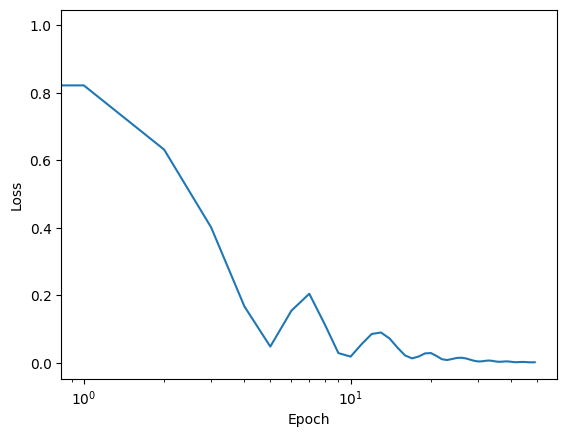

In [11]:
plt.plot(losses)
plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

(10, 29)


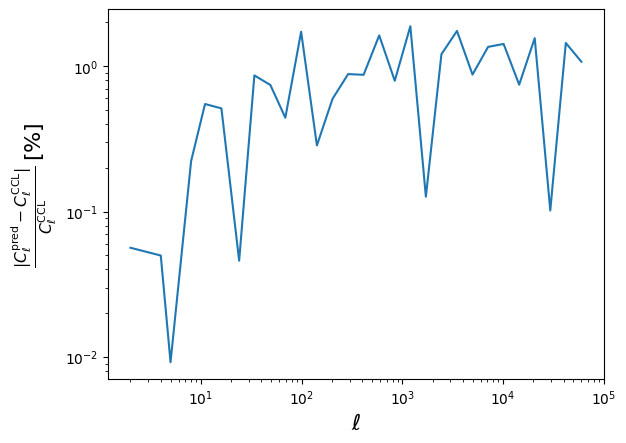

In [12]:
pred = CosStandard.predict(X_test)
print(pred.shape)
pred = scaler_y.inverse_transform(pred)
plt.figure()
i = 0
plt.loglog(l_arr, (abs(pred[i]-y_test[i])/y_test[i] * 100), label='Predicted', ls='-')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$\frac{|C_{\ell}^{\rm pred} - C_{\ell}^{\rm CCL}|}{C_{\ell}^{\rm CCL}} \, [\%]$', fontsize=16)
plt.savefig('Cgg_pred_bias.png', bbox_inches='tight')

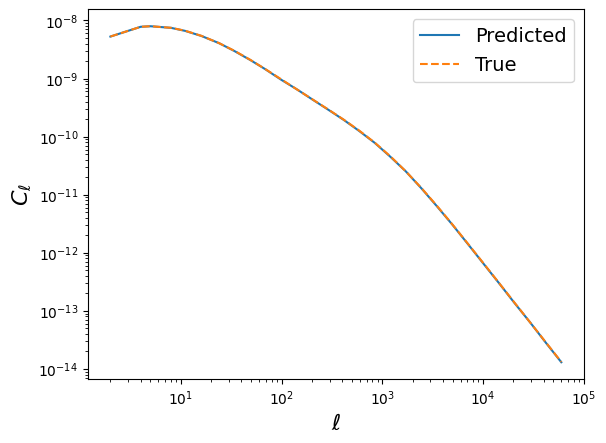

In [13]:
plt.loglog(l_arr, pred[i], label='Predicted', ls='-')
plt.loglog(l_arr, y_test[i], label='True', ls='--')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$C_{\ell}$', fontsize=16)
plt.legend(fontsize=14)
plt.savefig('Cgg_pred.png', bbox_inches='tight')

Clearly the model cannot accurately predict the C_ell for a different redshift distribution

## Try use MAML to allow for different source distributiuons to be used

In [8]:
# training data in this case needs different source dists
n_samples = 50
n_tasks = 100
seed = 14

Omega_b_arr = np.linspace(0.04, 0.06, n_samples)
Omega_c_arr = np.linspace(0.25, 0.35, n_samples)
h_arr = np.linspace(0.6, 0.8, n_samples)
sigma8_arr = np.linspace(0.7, 0.9, n_samples)
n_s_arr = np.linspace(0.9, 1.1, n_samples)

z = np.linspace(0., 3., 256)
rng = np.random.RandomState(seed)
    
l_arr = np.unique(np.geomspace(2, 60000, 30).astype(int))

if os.path.isfile('Cgg_data_multi_task.npz'):
    C_ells = np.load('Cgg_data_multi_task.npz')['C_ells']
    z0 = np.load('Cgg_data_multi_task.npz')['z0']
    dndz = np.load('Cgg_data_multi_task.npz')['dndz']
else:
    C_ells = np.empty((n_samples, n_tasks, len(l_arr)))
    z0 = np.empty(n_tasks)
    dndz = np.empty((n_tasks, len(z)))
    for i in tqdm.trange(n_tasks):
        z0[i] = rng.uniform(0.1, 0.3)
        dndz[i,:] = 1./(2.*z0) * (z / z0)**2 * np.exp(-z/z0)
        plt.plot(z, dndz)
        for j in range(n_samples):
            cosmo = ccl.Cosmology(Omega_c=Omega_c_arr[j], Omega_b=Omega_b_arr[j],
                                h=h_arr[j], sigma8=sigma8_arr[j], n_s=n_s_arr[j])
            lensTracer = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz[i,:]))
            C_ells[j,i,:] = ccl.angular_cl(cosmo, lensTracer, lensTracer, l_arr)

    np.savez('Cgg_data_multi_task.npz', C_ells=C_ells, l_arr=l_arr, Omega_b_arr=Omega_b_arr,
                Omega_c_arr=Omega_c_arr, h_arr=h_arr, sigma8_arr=sigma8_arr, n_s_arr=n_s_arr,
                z0=z0, dndz=dndz)
    
    C_ells = np.load('Cgg_data_multi_task.npz')['C_ells']
    z0 = np.load('Cgg_data_multi_task.npz')['z0']
    dndz = np.load('Cgg_data_multi_task.npz')['dndz']

C_ell data
- Rows are different samples.
- Columns are different tasks. 

[44  2 45 30  6  9 30 36 27 30 31 28 14 33 16 46 40 39  5 18 12 15 13  5
 20 11 24 20 36 48 48 36 30 46 47 16 13 36 26  5 42 39 45 33  0 30  0 27
 14 38 38]


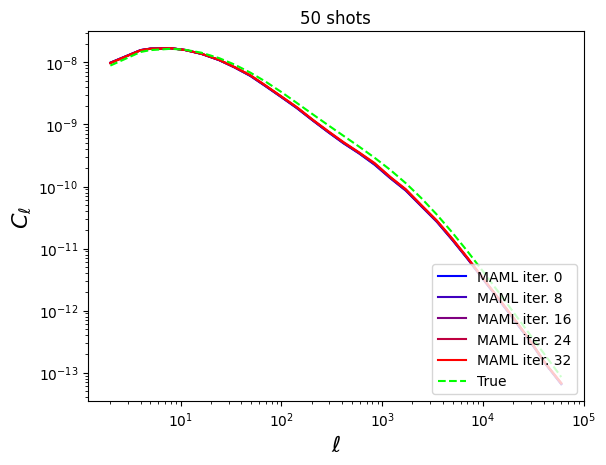

-----------------------------
iteration  0
meta-loss 0.8607166264339584
plot loss 0.5385490627634549


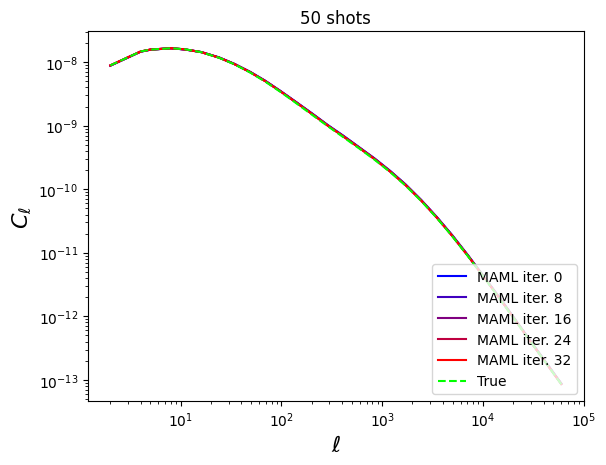

-----------------------------
iteration  10
meta-loss 0.03898282061132697
plot loss 0.014883704769438925


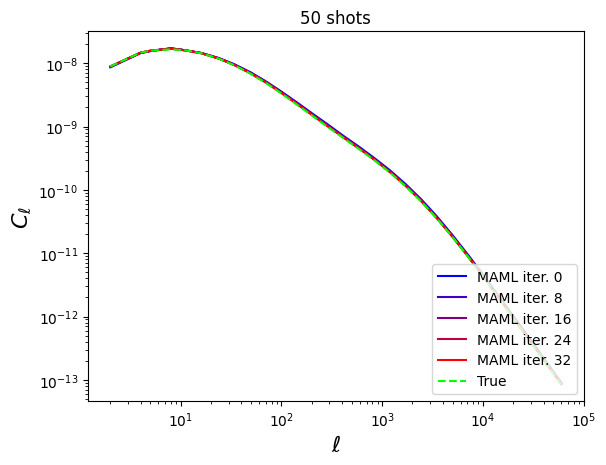

-----------------------------
iteration  20
meta-loss 0.19691548069583562
plot loss 0.04516157825227157


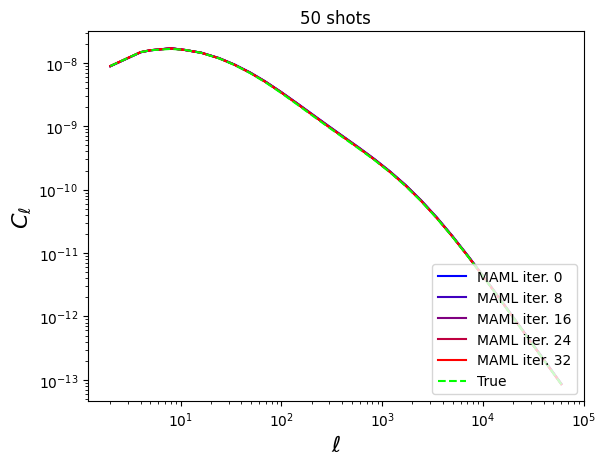

-----------------------------
iteration  30
meta-loss 0.07987885760082056
plot loss 0.026667947497877334


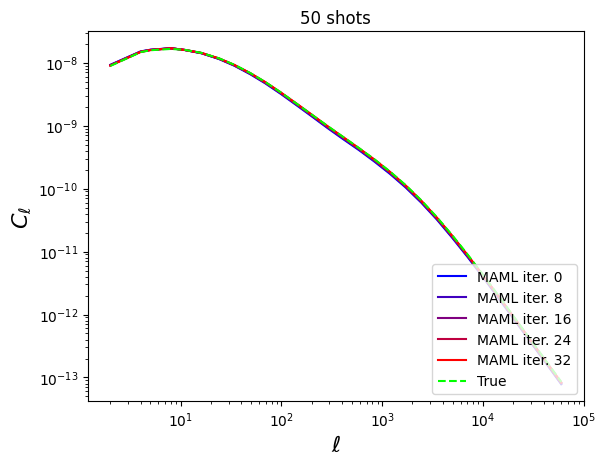

-----------------------------
iteration  40
meta-loss 0.13250242067129162
plot loss 0.040003671317937715


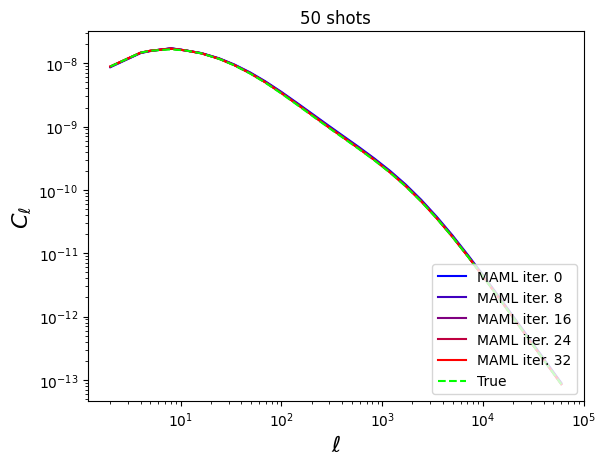

-----------------------------
iteration  50
meta-loss 0.24634092786310335
plot loss 0.056311764010565035


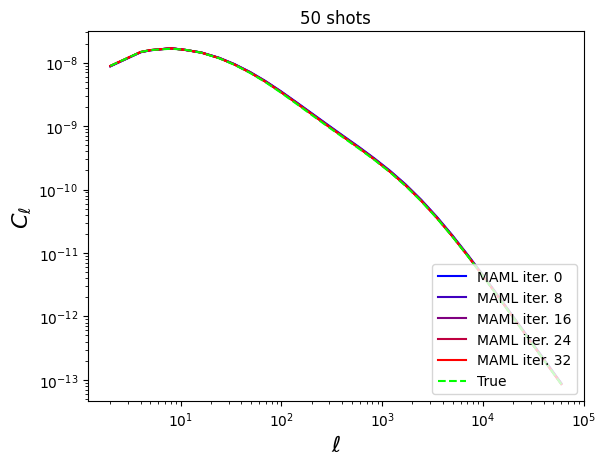

-----------------------------
iteration  60
meta-loss 0.09139180837051197
plot loss 0.02481688909182732


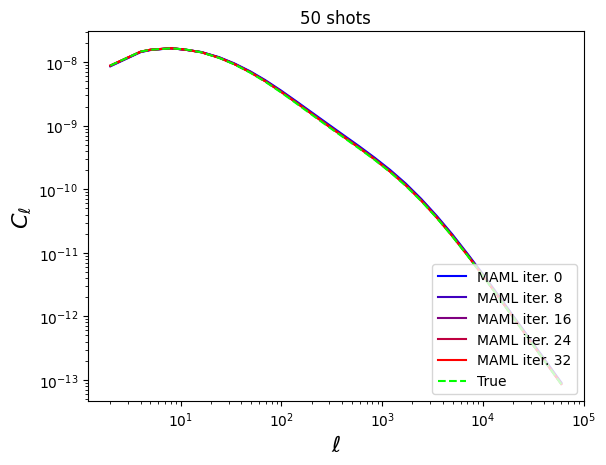

-----------------------------
iteration  70
meta-loss 0.12753224162853355
plot loss 0.028715848140411365


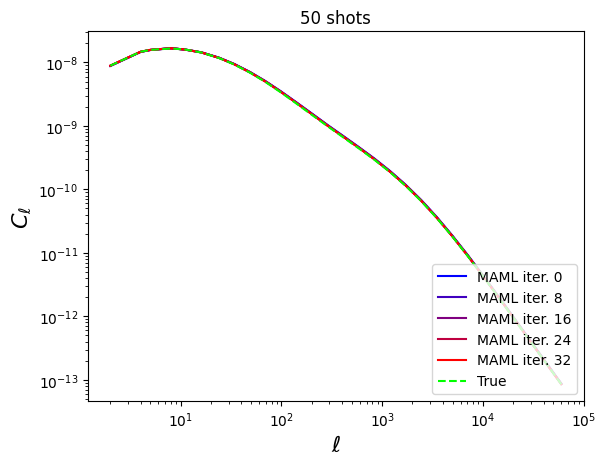

-----------------------------
iteration  80
meta-loss 0.11311597408716174
plot loss 0.009332315139658499


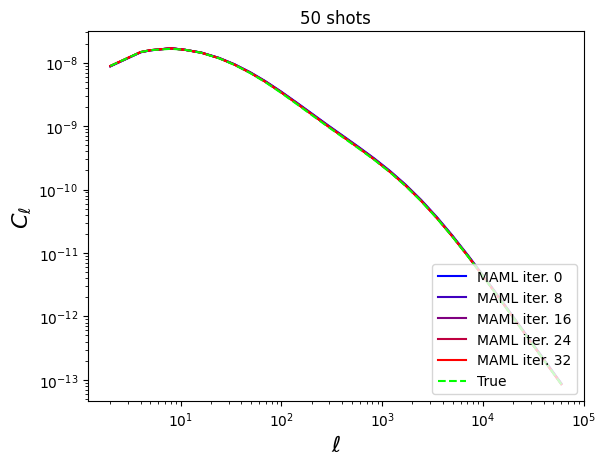

-----------------------------
iteration  90
meta-loss 0.09400822843883488
plot loss 0.02135394129386967


In [22]:
seed = 666
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

CosmEmbryo = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, len(l_arr))
)

# collate training data
scaler_x = StandardScaler()
X_all = np.vstack((Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr)).T
X_all = scaler_x.fit_transform(X_all)

# send model to GPU
CosmEmbryo.to('cuda')

inner_epochs = 1
batch_size = 50

inner_step_size = 1e-2
inner_decay = 1e-4
outer_step_size = 5e-1
outer_decay = 1e-4
loss_fn = nn.MSELoss() # loss function

outer_optimizer = torch.optim.SGD(CosmEmbryo.parameters(), lr=outer_step_size, weight_decay=outer_decay)

def to_torch(x):
    return ag.Variable(torch.tensor(x, dtype=torch.float32).to('cuda'))

def train_on_batch(x, y):
    x = to_torch(x)
    y = to_torch(y)
    CosmEmbryo.zero_grad()
    pred = CosmEmbryo(x)
    loss = loss_fn(pred, y)
    loss.backward()
    for param in CosmEmbryo.parameters():
        param.data -= inner_step_size * param.grad.data

def predict(x):
    x = to_torch(x)
    return CosmEmbryo(x).detach().cpu().numpy()

# Generate new task to test on
n_shot = 50
rand_inds = rng.choice(n_samples, size=n_shot+1)
print(rand_inds)
xtrain_plot = X_all[rand_inds[:-1],:]

task_plot = 0
y_plot = C_ells[:,task_plot,:]
scaler_plot = StandardScaler()
y_plot = scaler_plot.fit_transform(y_plot)

# Training loop
# Outer loop trains on different tasks
for i in range(n_tasks):
    task = rng.choice(n_tasks, size=1)[0]
    if task == task_plot:
        continue
    weights_before = copy.deepcopy(CosmEmbryo.state_dict())

    inds = rng.permutation(n_samples)
    train_inds = inds[:-1*batch_size]
    test_inds = inds[-1*batch_size:]
    y_all = C_ells[:,task,:] # all samples for this task
    scaler_y = StandardScaler()
    y_all = scaler_y.fit_transform(y_all)

    # Inner loop trains on different inputs for the same task
    with higher.innerloop_ctx(CosmEmbryo, 
                              torch.optim.SGD(CosmEmbryo.parameters(), 
                              lr=inner_step_size, weight_decay=inner_decay)) as (fmodel, diffopt):
        # Inner loop
        for _ in range(inner_epochs):
            for start in range(0, len(train_inds), batch_size):
                batch_inds = train_inds[start:start + batch_size]
                x = to_torch(X_all[batch_inds, :])
                y = to_torch(y_all[batch_inds, :])

                # Forward pass and update
                pred = fmodel(x)
                loss = loss_fn(pred, y)
                diffopt.step(loss)

    # Outer loop (meta-update)
    CosmEmbryo.load_state_dict(weights_before)
    for start in range(0, len(test_inds), batch_size):
        batch_inds = test_inds[start:start + batch_size]
        x = to_torch(X_all[batch_inds, :])
        y = to_torch(y_all[batch_inds, :])

        CosmEmbryo.zero_grad()
        pred = CosmEmbryo(x)
        loss = loss_fn(pred, y)
        loss.backward()

        # Adam optimizer step for outer loop
        outer_optimizer.step()

    if i % 10 == 0:
        plt.cla()
        plt.title(f'%d shots'%n_shot)
        weights_before = copy.deepcopy(CosmEmbryo.state_dict())
        y_pred_init = predict(X_all)
        y_pred_init = scaler_plot.inverse_transform(y_pred_init)
        plt.loglog(l_arr, y_pred_init[rand_inds[-1],:], 
                   label='MAML iter. 0', ls='-', color=(0,0,1))
        
        for inneriter in range(32):
            train_on_batch(xtrain_plot, y_plot[rand_inds[:-1],:])
            if (inneriter + 1) % 8 == 0:
                y_pred_update = predict(X_all)
                y_pred_update = scaler_plot.inverse_transform(y_pred_update)
                frac = (inneriter+1)/32
                plt.loglog(l_arr, y_pred_update[rand_inds[-1],:], 
                        label=f'MAML iter. {inneriter+1}', ls='-', color=(frac, 0, 1-frac))
                
        plt.loglog(l_arr, C_ells[rand_inds[-1],task_plot,:],
                    label='True', ls='--', color=(0,1,0))
        plotloss = np.square(predict(X_all)[rand_inds[-1],:] - y_plot[rand_inds[-1],:]).mean()
        plt.legend(loc="lower right")
        plt.xlabel(r'$\ell$', fontsize=16)
        plt.ylabel(r'$C_{\ell}$', fontsize=16)
        plt.pause(0.01)
        CosmEmbryo.load_state_dict(weights_before)  # restore from snapshot
        print(f"-----------------------------")
        print(f"iteration  {i}")
        metaloss = np.square(predict(X_all) - y_plot).mean()
        print(f"meta-loss {metaloss}")
        print(f"plot loss {plotloss}")

torch.cuda.empty_cache()
